# **Base Model**

This is initial model that was provided this no modification

Validation Loss: 5.016
Validation Accuracy: 37.45%
FLOPS: 0.69G


In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Nathaniel Chang, Tommy Hick
### Student ID: a1821595, a1825267
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 37.45% FLOPs: 0.69G
##################################################################################################################################

In [2]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = './animal/dataset/dataset/'
classes = os.listdir(data_dir)

In [4]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [5]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [6]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [7]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


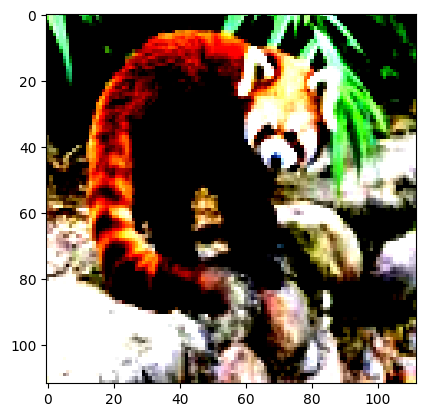

In [8]:
show_image(*dataset[200])

In [9]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [10]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [11]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


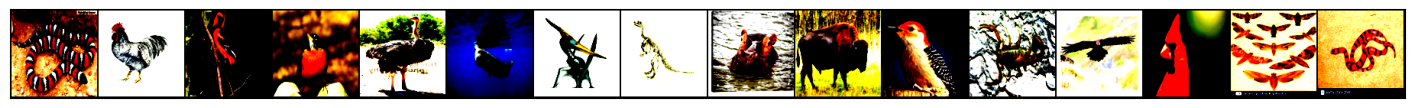

In [12]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [13]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 3*112*112
output_size = 151

In [20]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [21]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [22]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-4.9810, -4.9628, -5.0004, -5.1166, -5.0207, -4.9754, -5.0287, -5.0343,
        -4.9360, -5.0579, -4.9739, -5.0181, -5.0816, -4.9687, -4.9360, -4.9672,
        -5.0258, -4.9406, -5.0533, -5.0462, -5.0246, -4.9779, -4.9872, -5.0308,
        -5.0082, -5.0983, -5.0357, -5.0262, -5.0195, -4.9694, -4.9170, -5.1058,
        -5.0232, -5.0241, -5.0034, -5.0520, -4.9604, -5.0360, -5.0646, -4.9893,
        -4.9578, -5.0355, -5.0061, -5.0049, -5.0020, -5.0383, -5.0278, -5.0336,
        -5.0096, -4.9908, -5.0240, -5.0019, -4.9970, -5.0736, -5.0690, -5.0367,
        -4.9537, -5.0003, -5.0393, -5.0141, -4.9773, -4.9391, -4.9872, -4.9851,
        -5.0518, -5.1146, -5.0664, -4.9889, -5.0137, -5.0829, -4.9924, -4.9548,
        -5.0350, -4.9460, -5.0569, -5.0219, -5.0776, -5.0656, -5.0113, -5.0106,
        -5.0152, -4.9609, -5.0398, -4.9941, -4.9092, -5.0280, -5.0567, -4.9632,
        -5.0684, -4.9715, -5.0328, 

In [23]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [24]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
model = to_device(model, device)

In [26]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.020401954650879, 'val_acc': 0.015625}]

In [27]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [28]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8155, val_loss: 4.5634, val_acc: 0.1080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2369, val_loss: 4.2035, val_acc: 0.2073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7248, val_loss: 4.0203, val_acc: 0.2566


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2704, val_loss: 3.7099, val_acc: 0.3528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8699, val_loss: 3.7928, val_acc: 0.3816


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4970, val_loss: 3.8591, val_acc: 0.3497


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.1576, val_loss: 3.9476, val_acc: 0.3920


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.8643, val_loss: 4.4483, val_acc: 0.3372


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.5983, val_loss: 4.6634, val_acc: 0.3573


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.3605, val_loss: 5.1438, val_acc: 0.3698


In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

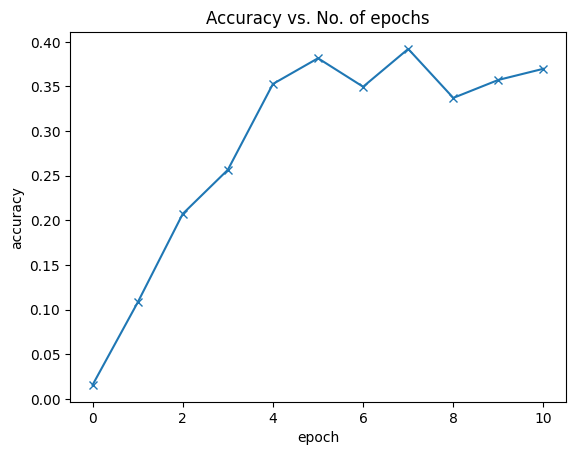

In [30]:
plot_accuracies(history)

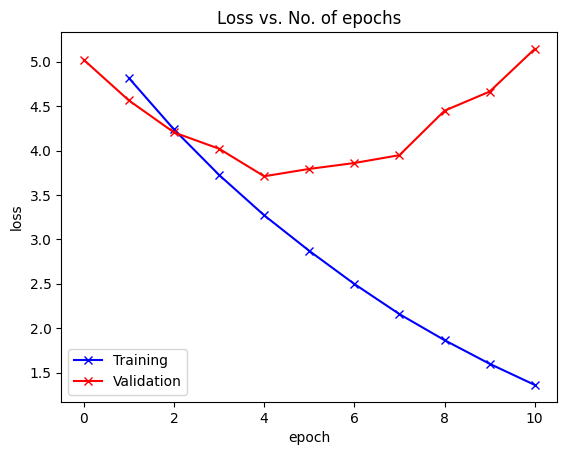

In [31]:
plot_losses(history)

In [32]:
evaluate(model, test_loader)

{'val_loss': 5.015594005584717, 'val_acc': 0.37447917461395264}

## FLOPs

In [34]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G
